## 3.3 Experiments – 20 marks

### 3.3.1 Design experiments to test the following: The utility of the data that you have generated using your proposed anonymisation scheme (algorithms) for Q2.c.

First, we start with preprocessing measures to ensure we can compare the utility of our data accordingly. 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

def interval_to_middle(value):
    if pd.isna(value):
        return np.nan  
    start, end = value.split('-')
    start = int(start)
    end = int(end)
    # Calculate the middle value of the interval
    middle = (start + end) / 2
    return middle

# Apply preprocessing measures to be able to compare our two datasets
orig_df = pd.read_csv("police-shooting.csv")
orig_df = orig_df.drop(['city', 'name', 'longitude', 'latitude', 'is_geocoding_exact', 'id'], axis=1)

orig_df['year'] = pd.to_datetime(orig_df['date']).dt.year
orig_df = orig_df.drop(['date'], axis=1)

anon_df = pd.read_csv("k_anon_police.csv")
anon_df['year'] = anon_df['year_range'].apply(interval_to_middle)
anon_df['age'] = anon_df['age_range'].apply(interval_to_middle)
anon_df = anon_df.drop(['year_range', 'age_range', 'id'], axis=1)

When preprocessing is done, we compare the cardinality of each of the attributes.

In [3]:
cardinalities_orig = {}
cardinalities_anon = {}

for column in orig_df.columns:
    u = orig_df[column].nunique() 
    n = orig_df[column].count()  
    c = u / n  # Cardinality calculation
    cardinalities_orig[column] = c
    
for column in anon_df.columns:
    u = anon_df[column].nunique() 
    n = anon_df[column].count()  
    c = u / n  # Cardinality calculation
    cardinalities_anon[column] = c

    
df_orig_cardinalities = pd.DataFrame(list(cardinalities_orig.items()), columns=['Attribute', 'Original Cardinality'])
df_anon_cardinalities = pd.DataFrame(list(cardinalities_anon.items()), columns=['Attribute', 'Anonymized Cardinality'])
combined_cardinalities = pd.merge(df_orig_cardinalities, df_anon_cardinalities, on='Attribute')
print(combined_cardinalities.to_string(index=False))

              Attribute  Original Cardinality  Anonymized Cardinality
        manner_of_death              0.000250                0.000250
                  armed              0.013628                0.013628
                    age              0.010816                0.000401
                 gender              0.000251                0.000251
                   race              0.000927                0.000927
                  state              0.006384                0.006384
signs_of_mental_illness              0.000250                0.000250
           threat_level              0.000376                0.000376
                   flee              0.000569                0.000569
            body_camera              0.000250                0.000250
                   year              0.001001                0.000376


Then, we proceed by displaying the minimum value, mean value, 25th percentile value, 75th percentile value, standard derivation and the total value count for the numerical values in both of the datasets.

In [4]:
stats_original = orig_df.describe().transpose()
stats_anonymized = anon_df.describe().transpose()

stats_original.columns = ['orig_' + col for col in stats_original.columns]
stats_anonymized.columns = ['anon_' + col for col in stats_anonymized.columns]

combined_stats = pd.merge(stats_original, stats_anonymized, left_index=True, right_index=True)

combined_stats

,orig_count,orig_mean,orig_std,orig_min,orig_25%,orig_50%,orig_75%,orig_max,anon_count,anon_mean,anon_std,anon_min,anon_25%,anon_50%,anon_75%,anon_max
age,7489.0,37.215917,12.986545,2.0,27.0,35.0,45.0,92.0,7489.0,38.072573,17.868025,15.0,15.0,45.5,45.5,80.5
year,7989.0,2018.536863,2.290178,2015.0,2017.0,2019.0,2021.0,2022.0,7989.0,2019.483352,2.556590,2016.5,2016.5,2020.0,2023.0,2023.0


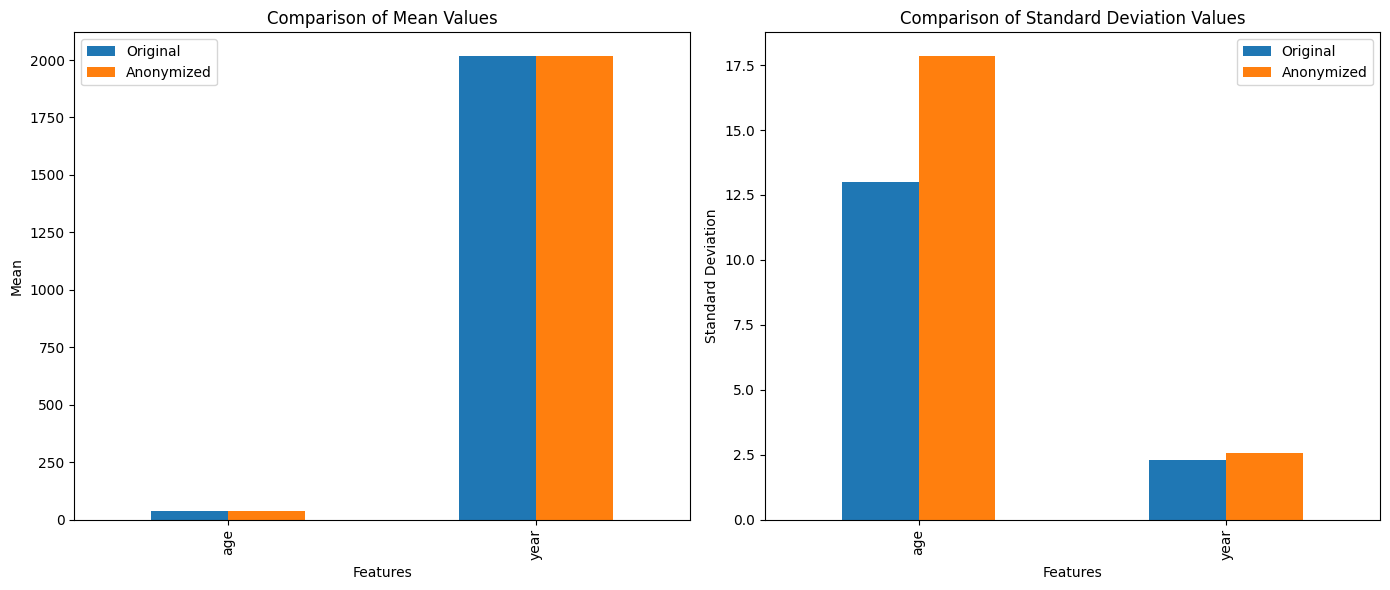

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

combined_stats[['orig_mean', 'anon_mean']].plot(kind='bar', ax=ax[0])
ax[0].set_title('Comparison of Mean Values')
ax[0].set_ylabel('Mean')
ax[0].set_xlabel('Features')
ax[0].legend(["Original", "Anonymized"])

combined_stats[['orig_std', 'anon_std']].plot(kind='bar', ax=ax[1])
ax[1].set_title('Comparison of Standard Deviation Values')
ax[1].set_ylabel('Standard Deviation')
ax[1].set_xlabel('Features')
ax[1].legend(["Original", "Anonymized"])

plt.tight_layout()
plt.show()

We now progress in comparing if there is a difference in the number of missing values in the two datasets. 

In [6]:
missing_original = orig_df.isnull().sum()
missing_anonymized = anon_df.isnull().sum()

original_missing_percentage = (missing_original / len(orig_df)) * 100
anonymized_missing_percentage = (missing_anonymized / len(anon_df)) * 100

completeness_comparison = pd.DataFrame({
    'original_missing_perc': original_missing_percentage,
    'anonymized_missing_percentage': anonymized_missing_percentage
})

completeness_comparison

,original_missing_perc,anonymized_missing_percentage
age,6.258606,6.258606
armed,2.641132,2.641132
body_camera,0.000000,0.000000
flee,11.978971,11.978971
gender,0.388034,0.388034
manner_of_death,0.000000,0.000000
race,18.976092,18.976092
signs_of_mental_illness,0.000000,0.000000
state,0.000000,0.000000
threat_level,0.000000,0.000000


We now proceed with calculating the pearson coefficient in numerical attributes of our two datasets. The Pearson correlation coefficient measures the linear correlation between two sets of data, ranging from -1 to 1. A coefficient of 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative linear relationship, and 0 indicates no linear relationship.

In [7]:
from scipy.stats import pearsonr
correlations = {}

for column in orig_df.columns:
    if column in anon_df.columns and orig_df[column].dtype in [np.float64, np.int64, np.int32]:
        combined = pd.concat([orig_df[column], anon_df[column]], axis=1, keys=['original', 'anonymized']).dropna()
        correlation = pearsonr(combined['original'], combined['anonymized'])[0]
        correlations[column] = correlation

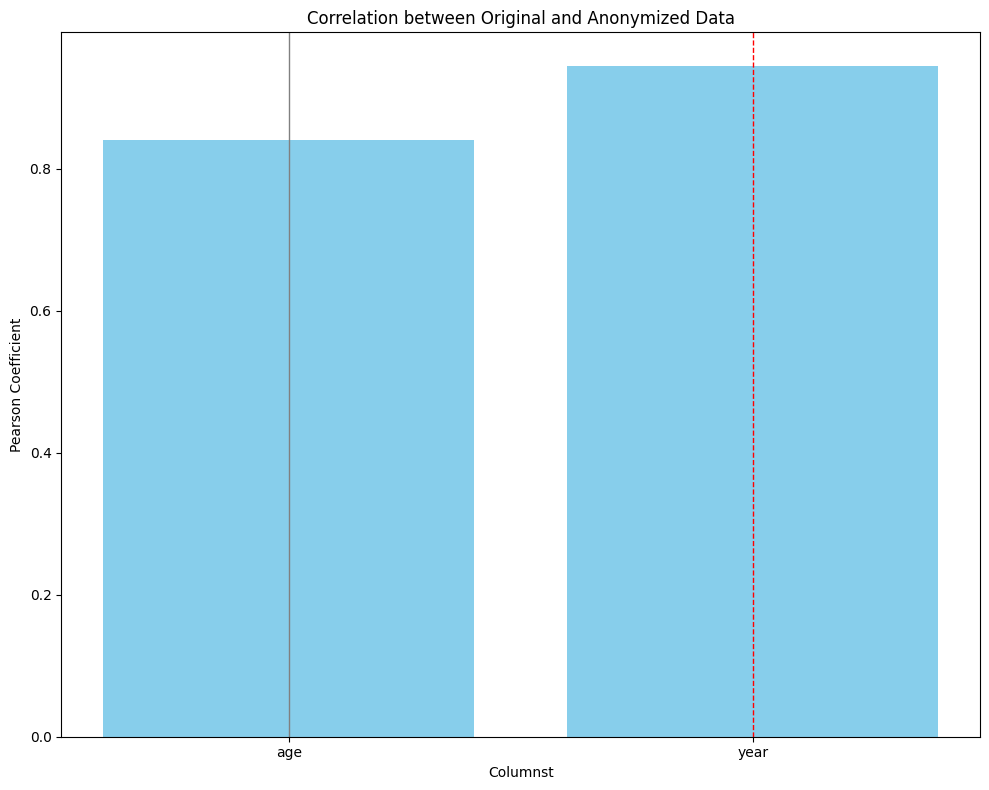

In [8]:
columns = list(correlations.keys())
correlation_values = list(correlations.values())

plt.figure(figsize=(10, 8)) 
plt.bar(columns, correlation_values, color='skyblue')  
plt.xlabel('Columnst')
plt.ylabel('Pearson Coefficient')
plt.title('Correlation between Original and Anonymized Data')
plt.axvline(x=0, color='grey', lw=1)  
plt.axvline(x=1, color='red', linestyle='--', lw=1) 
plt.tight_layout() 
plt.savefig('correlation_plot.png')

plt.show()

In the following, we calculate the Mean Absolute Error (MAE) and Root Mean Square Error (RMSE) between the two datasets. 

In [9]:
def calculate_correlations(data_original, data_anonymized):
    column_correlations = {}
    for column_name in data_original.columns:
        if column_name in data_anonymized.columns and data_original[column_name].dtype in [np.float64, np.int64, np.int32]:
            combined_data = pd.concat([data_original[column_name], data_anonymized[column_name]], axis=1, keys=['data_orig', 'data_anon']).dropna()
            corr_value = pearsonr(combined_data['data_orig'], combined_data['data_anon'])[0]
            column_correlations[column_name] = corr_value
    return column_correlations


def compute_similarity_metrics(dataset_original, dataset_anonymized):
    metrics_results = {}

    correlation_scores = calculate_correlations(dataset_original, dataset_anonymized)
    metrics_results['correlation_scores'] = correlation_scores
    errors_mae = {}
    errors_rmse = {}
    for column_name in dataset_original.columns:
        if column_name in dataset_anonymized.columns and dataset_original[column_name].dtype in [np.float64, np.int64, np.int32]:
            data_orig_col = dataset_original[column_name].dropna()
            data_anon_col = dataset_anonymized.loc[data_orig_col.index, column_name]
            mae_value = np.mean(np.abs(data_orig_col - data_anon_col))
            rmse_value = np.sqrt(np.mean((data_orig_col - data_anon_col) ** 2))
            errors_mae[column_name] = mae_value
            errors_rmse[column_name] = rmse_value

    return {'Errors_MAE': errors_mae, 'Errors_RMSE': errors_rmse}

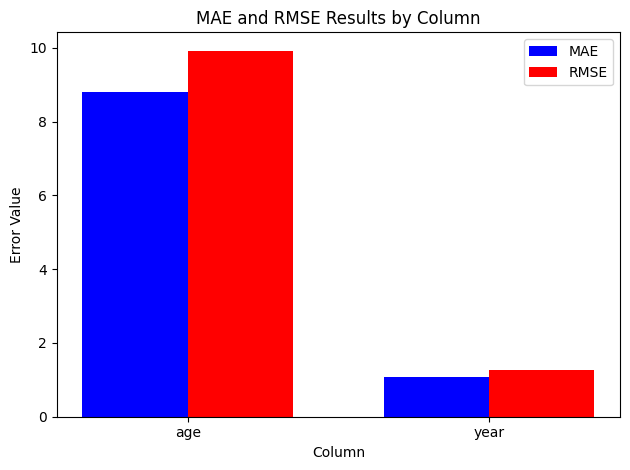

In [10]:
similarity_results = compute_similarity_metrics(orig_df, anon_df)
mae_results = similarity_results['Errors_MAE']
rmse_results = similarity_results['Errors_RMSE']

columns = list(mae_results.keys())  # Column names
mae_values = list(mae_results.values())  # MAE values
rmse_values = list(rmse_results.values())  # RMSE values

fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(columns))
ax.bar(index, mae_values, bar_width, label='MAE', color='blue')
ax.bar([p + bar_width for p in index], rmse_values, bar_width, label='RMSE', color='red')
ax.set_xlabel('Column')
ax.set_ylabel('Error Value')
ax.set_title('MAE and RMSE Results by Column')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(columns)
ax.legend()
plt.tight_layout()
plt.show()

### 3.3.2 Design experiments to test the following: Analyse the new (anonymized) dataset for risks of de-anonymization.
We are using the same Algorithm proposed in Task 3.2

In [11]:
import pandas as pd
from scipy import stats
import numpy as np
import prince
import warnings
import altair as alt
alt.data_transformers.enable("vegafusion")

df = pd.read_csv('k_anon_police.csv')
# Ignore specific PerformanceWarnings from pandas
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
# Load the dataset

mca = prince.MCA(
    n_components=3,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
# Fit FAMD on the dataset
mca = mca.fit(df)

df_transformed = mca.transform(df)
z_scores = np.abs(stats.zscore(df_transformed))
outliers = np.where(z_scores > 3) 

outlier_rows = df.iloc[outliers[0]]
outlier_rows.to_csv('athletes_outliers_MCA.csv', index=False)

mca.plot(
    df,
    x_component=0,
    y_component=1,
    show_column_markers=True,
    show_row_markers=True,
    show_column_labels=False,
    show_row_labels=False
)

alt.LayerChart(...)

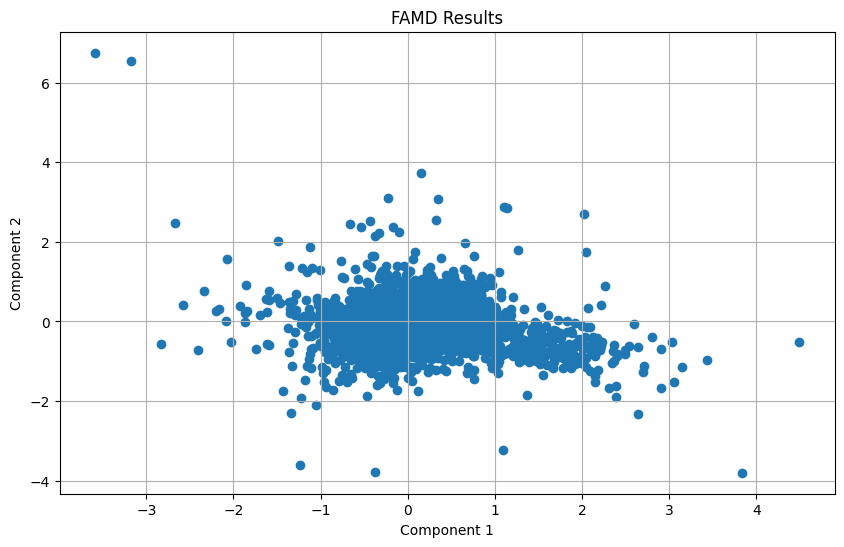

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  
plt.scatter(df_transformed[0], df_transformed[1]) 

plt.title('FAMD Results')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)

plt.show() 

### 3.3.3 Design experiments to test the following: Propose a method of assessing the risk of disclosure (de-anonymisation) and use this metric to evaluate your anonymised datasets (from Assignments #1, and #2-3), the anonymised dataset received from your colleague, and your version of the anonymised dataset that you obtained in Q2.c.
